# Hilbert-Schmidt Independence Criterion (HSIC)

In [3]:
import sys
sys.path.append("../../../")

import objax
import jax
import jax.numpy as np

from jaxkern.kernels.stationary import RBF
from jaxkern.kernels.linear import Linear
from jaxkern.similarity.hsic import HSIC, CKA, HSICRBF, CKARBF
from jaxkern.kernels.sigma import estimate_sigma_median

from jaxkern.data.similarity import generate_data

# 
import numpy as onp

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

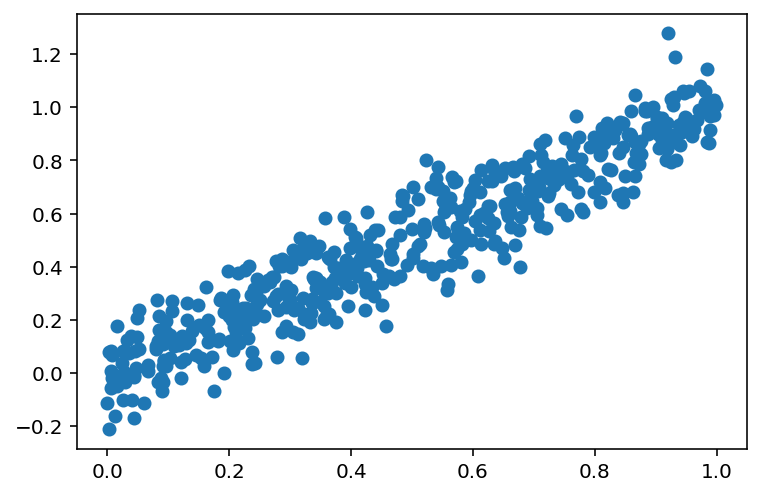

In [96]:
# random state
seed = 123
rng = onp.random.RandomState(seed)

# generate fake data
n_samples = 500
noise_y = 0.1

X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

X = np.array(X)
Y = np.array(Y)

plt.scatter(X, Y)

## HSIC - From Scratch

#### 1. Calculate Kernel Matrices

In [97]:
from objax.typing import JaxArray
def linear_kernel_f(x: JaxArray, y: JaxArray) -> JaxArray:
    """
    Linear Kernel Function
    """
    return np.dot(x, y)

**Note**: This outputs a scalar value. So we need to calculate all pairwise coordinates for the data, $\mathbf{K}$.

$$
K(\mathbf{X}_i, \mathbf{Y}_j)  = \exp \left( - \frac{||\mathbf{X_i-Y_j}||_2^2}{2 \sigma^2}  \right)
$$

In [98]:
from typing import Callable

def kernel_matrix(
    func: Callable,
    x: JaxArray,
    y: JaxArray,
) -> JaxArray:
    """
    Computes the covariance matrix.
    """
    mapx1 = jax.vmap(lambda x, y: func(x, y), in_axes=(0, None), out_axes=0)
    mapx2 = jax.vmap(lambda x, y: mapx1(x, y), in_axes=(None, 0), out_axes=1)
    return mapx2(x, y)

In [99]:
linear_kernel_matrix = jax.partial(kernel_matrix, linear_kernel_f)

# calculate kernel matrices
K_x = linear_kernel_matrix(X, X)
K_y = linear_kernel_matrix(Y, Y)

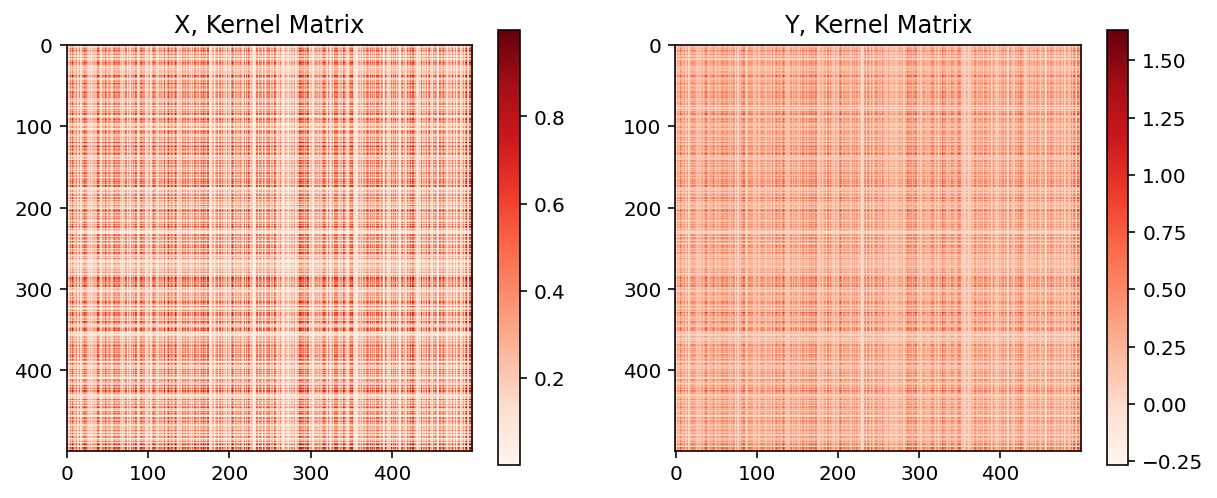

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_y, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

#### 2. Center Kernel Matices

$$
\mathbf{H}=\mathbf{I}_N - \left( \frac{1}{N}\right)\mathbb{1}_N
$$

where $\mathbf{I}$ is the identity matrix and $\mathbb{1}$ is a matrix of ones.

So centering a kernel matrix is:

$$
\bar{\mathbf{K}} = \mathbf{HKH} 
$$

In [101]:
def centering_matrix(n_samples: int) -> np.ndarray:
    """
    Calculates the centering matrix
    """
    H = np.eye(n_samples) - (1.0 / n_samples) * np.ones((n_samples, n_samples))

    return H

def center_kernel(K: np.ndarray) -> np.ndarray:
    """
    Center kernel matrix
    """
    H = centering_matrix(K.shape[0])
    
    K = np.einsum("ij,jk,kl->il", H, K, H)
    
    return K

In [102]:
from jaxkern.kernels.utils import centering

# center matrix
K_xc = center_kernel(K_x)
K_yc = center_kernel(K_y)

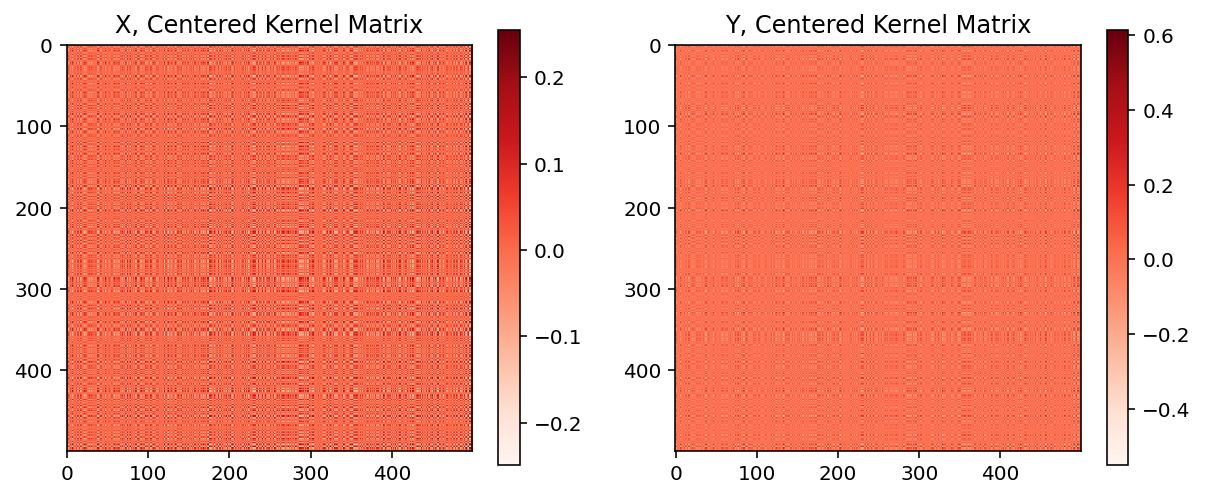

In [103]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_xc, cmap='Reds')
ax[0].set_title("X, Centered Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_yc, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

## 3. Summarize: HSIC Norm

Here we implement the HSIC norm which is a way to summarize the information with the matrices.

$$
\text{HSIC}(\mathbf{X}, \mathbf{Y}) = \langle \tilde{K}_x, \tilde{K}_y \rangle_{\text{HS}}
$$

### U-Statistic


$$
\text{HSIC}_\text{U}(\mathbf{X,Y}) = \\
\frac{(m-2)!}{m!} \sum_{ij}^{N} \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ij}} 
+ \frac{(m-4)!}{m!} \sum_{ij, kl}^{N} \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{kl}} 
- \frac{2(m-3)!}{m!} \sum_{ij, k}^{N} \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ik}} \\
$$

In [104]:
import math

def hsic_u_statistic_einsum(K_x: JaxArray, K_y: JaxArray) -> JaxArray:
    """
    Calculate the unbiased statistic
    """
    n_samples = K_x.shape[0]

    # Term 1
    a = math.factorial(n_samples - 2) / math.factorial(n_samples)
    A = np.einsum("ij,ij->", K_x, K_y)

    # Term 2
    b = math.factorial(n_samples - 4) / math.factorial(n_samples)
    B = np.einsum("ij,kl->", K_x, K_y)

    # Term 3
    c = 2 * math.factorial(n_samples - 3) / math.factorial(n_samples)
    C = np.einsum("ij,ik->", K_x, K_y)
    return a * A + b * B - c * C

In [105]:
hsic_u = hsic_u_statistic_einsum(K_x, K_y)

print(f"HSIC (U-stat): {hsic_u:.6e}")

hsic_u = hsic_u_statistic_einsum(K_xc, K_yc)

print(f"HSIC (U-stat, centered): {hsic_u:.6e}")

HSIC (U-stat): 6.815135e-03
HSIC (U-stat, centered): 6.857267e-03


#### Faster Version


We can do a faster version with matrix multiplication.

$$
\text{HSIC}_{\text{U}_f}(\mathbf{X,Y}) = \frac{1}{N(N-3)} \left[   \text{Tr}\left( \mathbf{\tilde{K_x} \tilde{K}_y} \right) \\+ \frac{\mathbf{1}^\top \mathbf{\tilde{K_x}}\mathbf{1}\mathbf{1}^\top \mathbf{\tilde{K_y}}\mathbf{1}}{(N-1)(N-2)} \\- \frac{2}{(N-2)} \mathbf{1}^\top \mathbf{\tilde{K_x}} \mathbf{\tilde{K_y}}\mathbf{1}\right]
$$

In [106]:
def hsic_u_statistic_dot(K_x: JaxArray, K_y: JaxArray) -> JaxArray:
    """
    Calculate the unbiased statistic
    """
    n_samples = K_x.shape[0]

    K_xd = K_x - np.diag(np.diag(K_x))
    K_yd = K_y - np.diag(np.diag(K_y))
    K_xy = K_xd @ K_yd.T

    # Term 1
    a = 1 / n_samples / (n_samples - 3)
    A = np.trace(K_xy)

    # Term 2
    ones_v = np.ones((n_samples, 1))
    b = a / (n_samples - 1) / (n_samples - 2)
    B = ones_v.T @ K_xd @ ones_v @ ones_v.T @ K_yd @ ones_v

    # Term 3
    c = (a * 2) / (n_samples - 2)
    C = ones_v.T @ K_xy @ ones_v
    return a * A.squeeze() + b * B.squeeze() - c * C.squeeze()

In [107]:
hsic_u = hsic_u_statistic_dot(K_x, K_y)

print(f"HSIC (U-stat): {hsic_u:.6e}")

hsic_u = hsic_u_statistic_dot(K_xc, K_yc)

print(f"HSIC (U-stat, centered): {hsic_u:.6e}")

HSIC (U-stat): 6.857365e-03
HSIC (U-stat, centered): 6.857347e-03


#### Normalized Variant

This can be difficult to interpret because it's not and it's not consistent (i.e. there is no approximate monotonic function that can describe HSIC as it grows). The HSIC metric is somewhat similar to the covariance matrix, we need to normalize by the sizes of the individual matrices.

In [108]:
def nhsic_stat(f, K_x, K_y):
    return f(K_x, K_y) / np.sqrt(f(K_x, K_x) * f(K_y, K_y))

In [130]:


nhsic_u = nhsic_stat(hsic_u_statistic_einsum, K_x, K_y)

print(f"nHSIC (U-stat): {nhsic_u:.8f}")

nhsic_u = nhsic_stat(hsic_u_statistic_einsum, K_xc, K_yc)

print(f"nHSIC (U-stat, centered): {nhsic_u:.8f}")

nHSIC (U-stat): 1.01153302
nHSIC (U-stat, centered): 0.89092809


### V-Statistic

$$
\text{HSIC}_{v}(\mathbf{X,Y}) = \frac{1}{N^2} \sum_{ij}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ij}} \\
+ \frac{1}{N^4} \sum_{ijkl}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{kl}} \\
- \frac{2}{N^3} \sum_{ijk}^N \mathbf{K}_{\mathbf{x},{ij}}\mathbf{K}_{\mathbf{y},{ik}}
$$

In [110]:
def hsic_v_statistic_einsum(K_x, K_y):
    n_samples = K_x.shape[0]
    A = np.einsum("ij,ij->", K_x, K_y) / n_samples ** 2
    B = np.einsum("ij,kl->", K_x, K_y) / n_samples ** 4
    C = np.einsum("ij,ik->", K_x, K_y) / n_samples ** 3
    return A + B - 2 * C

In [111]:
nhsic_v = nhsic_stat(hsic_v_statistic_einsum, K_x, K_y)

print(f"nHSIC (V-stat): {nhsic_v:.8f}")

nhsic_v = nhsic_stat(hsic_v_statistic_einsum, K_xc, K_yc)

print(f"nHSIC (V-stat, centered): {nhsic_v:.8f}")

nHSIC (V-stat): 0.89191633
nHSIC (V-stat, centered): 0.89092809


#### Faster Version

$$
\begin{aligned}
\text{HSIC}_{v_f}(\mathbf{X,Y}) &= \frac{1}{N^2} \langle \mathbf{\bar{K}_x},\mathbf{\bar{K}_y}\rangle \\
&= \frac{1}{N^2} \text{Tr}\left( \mathbf{\bar{K}_x \bar{K}_y} \right)
\end{aligned}
$$

where $\mathbf{\bar{K}} = \mathbf{HKH}$.

In [112]:
def hsic_v_statistic_trace(K_x, K_y):
    n_samples = K_x.shape[0]
    K_xc = center_kernel(K_x)
    K_yc = center_kernel(K_y)
    return np.einsum("ij,ij->", K_xc, K_yc) / n_samples ** 2

In [113]:
nhsic_v = nhsic_stat(hsic_v_statistic_trace, K_x, K_y)

print(f"nHSIC (V-stat): {nhsic_v:.8f}")

nhsic_v = nhsic_stat(hsic_v_statistic_trace, K_xc, K_yc)

print(f"nHSIC (V-stat, centered): {nhsic_v:.8f}")

nHSIC (V-stat): 0.89092809
nHSIC (V-stat, centered): 0.89092791


### RBF Kernel


$$
k(\mathbf{x,y}) = \exp \left( - \frac{||\mathbf{x-y}||_2^2}{2 \sigma^2}  \right)
$$

where the squared euclidean distance is defined by:

$$
||\mathbf{x-y}||_2^2 = \sum_{i}^N (\mathbf{x}_i - \mathbf{y}_i)^2
$$


In [122]:
def squared_euclidean_distance(x, y):
    """
    Euclidean Distance between two vectors
    """
    return np.sum((x - y) ** 2)


def rbf_kernel_f(length_scale, x, y):
    """
    RBF Kernel Function
    """
    dists = squared_euclidean_distance(x, y)
    scale = 1 / (2. * length_scale ** 2)
    return np.exp(- dists / scale)

In [123]:
# estimate sigma
σ_x = estimate_sigma_median(X, X)
σ_y = estimate_sigma_median(Y, Y)

print(f"σ_x: {σ_x:.4f}" )
print(f"σ_y: {σ_y:.4f}" )

# calculate kernel matrices
rbf_kernel_matrix_X = jax.partial(kernel_matrix, jax.partial(rbf_kernel_f, σ_x))
rbf_kernel_matrix_Y = jax.partial(kernel_matrix, jax.partial(rbf_kernel_f, σ_y))


# calculate kernel matrices
K_x = rbf_kernel_matrix_X(X, X)
K_y = rbf_kernel_matrix_Y(Y, Y)

σ_x: 0.0593
σ_y: 0.0669


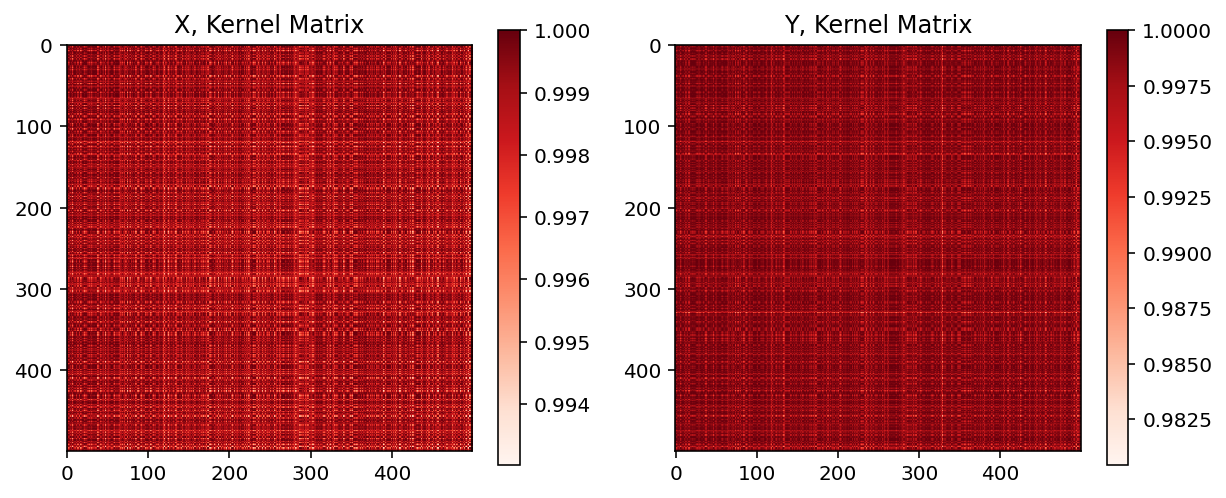

In [124]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(K_x, cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(K_y, cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Kernel Matrix")
plt.show()

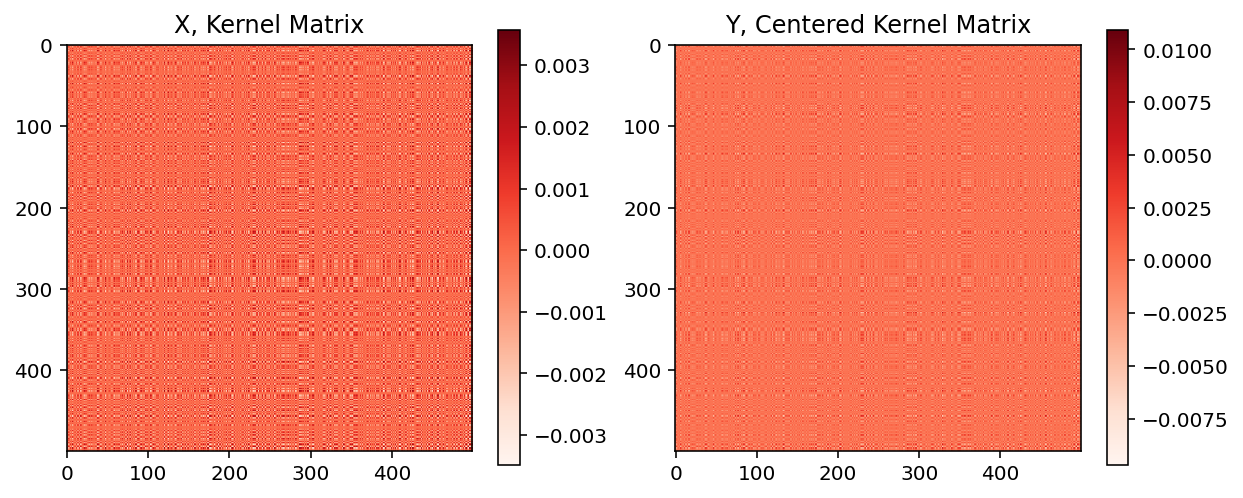

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
pts1 = ax[0].imshow(centering(K_x), cmap='Reds')
ax[0].set_title("X, Kernel Matrix")
fig.colorbar(pts1, ax=ax[0])
pts2 = ax[1].imshow(centering(K_y), cmap='Reds')
fig.colorbar(pts2, ax=ax[1])
ax[1].set_title("Y, Centered Kernel Matrix")
plt.show()

In [129]:
hsic_v = hsic_v_statistic_trace(K_x, K_y)

print(f"HSIC (V-stat): {hsic_v:.8f}")

nhsic_v = nhsic_stat(hsic_v_statistic_trace, K_x, K_y)

print(f"nHSIC (V-stat): {nhsic_v:.8f}")

HSIC (V-stat): 0.00000171
nHSIC (V-stat): 0.89105171


#### Convenience Function

Let's be honest, most people are going to use the RBF kernel. It's universal, quick n dirty, and quite simple to interpretate. So I made a convenience function to help people deal with it.

In [127]:
sigma_f = estimate_sigma_median

nhsic_clf = CKARBF(sigma_f, sigma_f)

nhsic_value = nhsic_clf(X, Y)

print(f"HSIC: {nhsic_value:.4f}")

HSIC: 0.9342


## Other Kernels



### RBF Kernel


#### Kernel Function

$$
k(\mathbf{x,y}) = \exp \left( - \frac{||\mathbf{x-y}||_2^2}{2 \sigma^2}  \right)
$$

where the squared euclidean distance is defined by:

$$
||\mathbf{x-y}||_2^2 = \sum_{i}^N (\mathbf{x}_i - \mathbf{y}_i)^2
$$


### Non-Linear

In [1]:
X = onp.random.randn(n_samples, 1)
Y = X**2 + 0.3 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

NameError: name 'onp' is not defined

#### Linear Kernel

In [17]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0369


#### RBF Kernel

In [18]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.3681


### Periodic

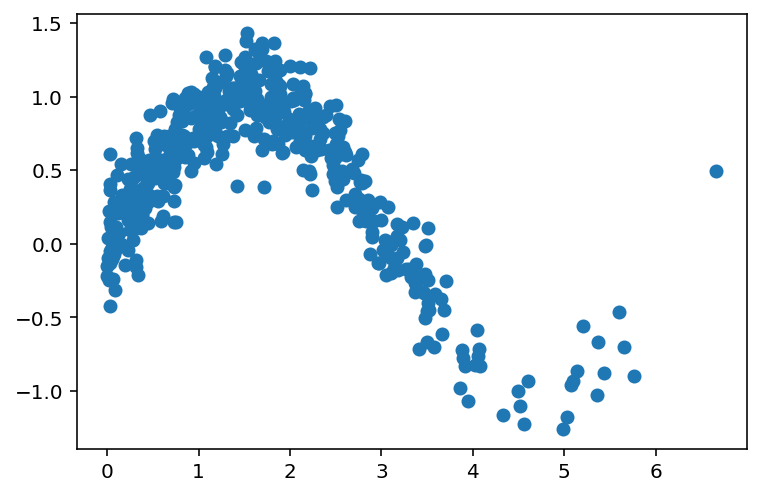

In [19]:
X = np.abs(2 * onp.random.randn(n_samples, 1))
Y = np.sin(X) + 0.2 * onp.random.randn(X.shape[0], X.shape[1])

plt.scatter(X, Y)

#### Linear Kernel

In [20]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.1890


#### RBF Kernel

In [21]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.3796


### Circle

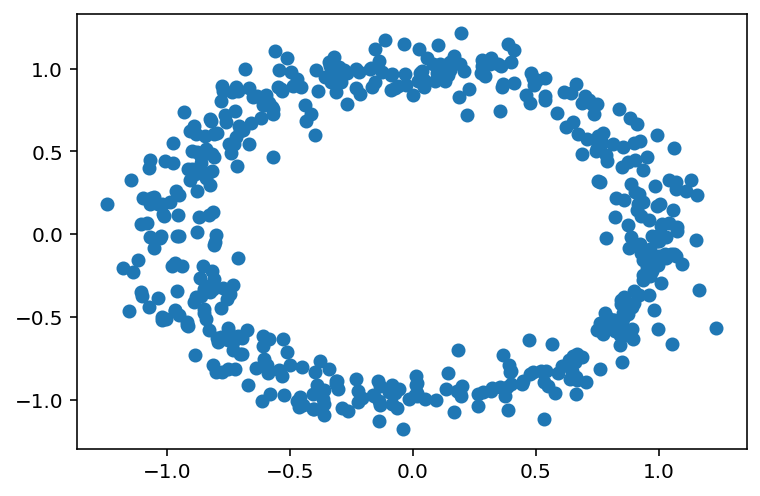

In [22]:
X, Y = generate_data(n_samples, "circle", noise_y=0.1, noise_x=0.1)

plt.scatter(X, Y)

#### Linear Kernel

In [23]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.4f}")

nHSIC (Linear): 0.0006


#### RBF Kernel

In [24]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.4f}")

nHSIC (RBF): 0.0357


### Random

In [36]:
X, Y = generate_data(n_samples, "random", noise_y=noise_y)

#### Linear Kernel

In [43]:
kernel = Linear()

# initialize HSIC model
nhsic_clf = CKA(kernel, kernel, bias=True)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (Linear): {nhsic_val:.2e}")

nHSIC (Linear): 2.88e-03


#### RBF Kernel

In [44]:
# estimate sigma
sigma_f = estimate_sigma_median

# initialize HSIC model
nhsic_clf = CKARBF(sigma_f, sigma_f)

# calculate HSIC
nhsic_val = nhsic_clf(X, Y)

print(f"nHSIC (RBF): {nhsic_val:.2e}")

nHSIC (RBF): 2.93e-03


## MMD Equivalent

In [28]:
X, Y = generate_data(n_samples, "linear", noise_y=noise_y)

In [29]:
# linear kernel
K_x = lin_kern(X, X)
K_y = lin_kern(Y, Y)

# center matrices
K_xc = centering(K_x)
K_yc = centering(K_y)

In [30]:
# get the expectrations
A = np.mean(K_xc * K_yc)
B = np.mean(np.mean(K_xc, axis=0) * np.mean(K_yc, axis=0))
C = np.mean(K_xc) * np.mean(K_yc)

In [31]:
print(f"A: {A:.2e}")
print(f"B: {B:.2e}")
print(f"C: {C:.2e}")

A: 6.84e-03
B: -1.03e-16
C: -3.26e-19


In [33]:
# calculate MMD
mmd_value = A - 2 * B + C

print(f"MMD: {mmd_value:.4f}")

MMD: 0.0068
